## Library

In [ ]:
!pip install datasets

In [2]:
import torch
import collections
import random
import numpy as np
from torch import nn
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, BertForMaskedLM, AdamW
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pad_sequence

## Dataset Loading

In [3]:
dataset = load_dataset("coastalcph/tydi_xor_rc")
train_set = dataset["train"]
validation_set = dataset["validation"]
df = pd.DataFrame(train_set)
df_eval = pd.DataFrame(validation_set)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/6.87M [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15326 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3028 [00:00<?, ? examples/s]

In [4]:
df.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang
0,উইকিলিকস কত সালে সর্বপ্রথম ইন্টারনেটে প্রথম তথ...,WikiLeaks () is an international non-profit or...,bn,True,182,2006,None
1,দ্বিতীয় বিশ্বযুদ্ধে কোন দেশ পরাজিত হয় ?,The war in Europe concluded with an invasion o...,bn,True,48,Germany,None
2,মার্কিন যুক্তরাষ্ট্রের সংবিধান অনুযায়ী মার্কিন...,Same-sex marriage in the United States expande...,bn,False,-1,no,None
3,আরব-ইসরায়েলি যুদ্ধে আরবের মোট কয়জন সৈন্যের মৃ...,The exact number of Arab casualties is unknown...,bn,True,39,unknown,None
4,বিশ্বে প্রথম পুঁজিবাদী সমাজ কবে গড়ে ওঠে ?,"As Thomas Hall (2000) notes, ""The Sung Empire ...",bn,True,1219,17th century,None


In [5]:
df_eval.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang
0,ఒరెగాన్ రాష్ట్రంలోని అతిపెద్ద నగరం ఏది ?,Portland is the largest city in the U.S. state...,te,True,0,Portland,None
1,కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?,"The word cholera is from ""kholera"" from χολή ""...",te,True,99,Indian subcontinent,None
2,కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?,Since it became widespread in the 19th century...,te,True,451,England,None
3,మొదటి ప్రపంచ యుద్ధం ఎప్పుడు మొదలయింది ?,World War I occurred from 1914 to 1918. In ter...,te,True,26,1914,None
4,మొదటి ప్రపంచ యుద్ధం ఎప్పుడు మొదలయింది ?,"World War I (often abbreviated as WWI or WW1),...",te,True,155,28 July 1914,None


# Language_Models

## Tokezination

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Function to tokenize questions
def tokenize_question(row):
    if row['lang'] in ['fi', 'ru', 'ja']:
        return tokenizer.tokenize(
            row['question']
        )
    else:
        return None

df['question_tokens'] = df.apply(tokenize_question, axis=1)
df_eval['question_tokens'] = df_eval.apply(tokenize_question, axis=1)

# Function to tokenize contexts
def tokenize_context(row):
    if row['lang'] in ['fi', 'ru', 'ja']:
        return tokenizer.tokenize(
            row['context']
        )
    else:
        return None


df['context_tokens'] = df.apply(tokenize_context, axis=1)
df_eval['context_tokens'] = df_eval.apply(tokenize_context, axis=1)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### tokenizer display

In [7]:
print(df['question_tokens'].head(3000))
print(df['context_tokens'].head(3000))
print(df_eval['question_tokens'].head(3000))
print(df_eval['context_tokens'].head())

0                                                    None
1                                                    None
2                                                    None
3                                                    None
4                                                    None
                              ...                        
2995    [オ, ##ン, ##ライン, ##ゲーム, ##の, 起, 源, は, ##い, ##つ, ？]
2996                            [唐, は, 中, 国, 統, 一, した, ？]
2997    [ル, ##ッ, ##キ, ##ズ, ##ム, ##に, ##より, 訴, 訟, に, 発,...
2998    [カ, ##ー, ##ダー, ##ル, ・, ヤ, ##ー, ##ノ, ##シ, ##ュ, ...
2999    [コ, ##ロ, ##ラ, ##ド, 州, 最, 初, の, 知, 事, は, ##だ, ##れ]
Name: question_tokens, Length: 3000, dtype: object
0                                                    None
1                                                    None
2                                                    None
3                                                    None
4                                                    None
                     

## Dataset Loader

In [8]:
class QuestionContextDataset(torch.utils.data.Dataset):
    def __init__(self, questions, contexts, question_tokens, context_tokens, labels, tokenizer, max_length=512):
        self.questions = questions
        self.contexts = contexts
        self.question_tokens = question_tokens
        self.context_tokens = context_tokens
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert question and context tokens to input IDs
        question_ids = self.tokenizer.convert_tokens_to_ids(self.question_tokens[idx])
        context_ids = self.tokenizer.convert_tokens_to_ids(self.context_tokens[idx])

        # Concatenate input_ids
        input_ids = question_ids + context_ids

        # Ensure the input is not longer than max_length
        if len(input_ids) > self.max_length:
            input_ids = input_ids[:self.max_length]

        # Create the attention mask (all 1s for actual tokens)
        attention_mask = [1] * len(input_ids)

        # Padding to max length if necessary
        padding_length = self.max_length - len(input_ids)
        if padding_length > 0:
            input_ids += [0] * padding_length
            attention_mask += [0] * padding_length

        # Convert labels to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': label
        }



def collate_fn(batch):
    # Extract input_ids, attention_mask, and labels from the batch
    input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]
    labels = [torch.tensor(item['labels'], dtype=torch.long) for item in batch]

    # Pad input_ids and attention_mask to the longest sequence in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    labels = torch.stack(labels)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels
    }



## Dataset for Finnish language

In [10]:
fi_train_df = df[df['lang'] == 'fi']

fi_val_df = df_eval[df_eval['lang'] == 'fi']

fi_train_df.head(100)

,question,context,lang,answerable,answer_start,answer,answer_inlang,question_tokens,context_tokens
9137,Mitkä olivat Rooman alkuvaiheet?,"In historiography, ancient Rome is Roman civil...",fi,True,0,"In historiography, ancient Rome is Roman civil...",None,"[Mit, ##kä, olivat, Rooma, ##n, al, ##ku, ##va...","[In, his, ##torio, ##graphy, ,, ancient, Rome,..."
9138,Kuka oli toisen maailmansodan jälkeisen sosial...,Rákosi had difficulty managing the economy and...,fi,True,187,Mátyás Rákosi,None,"[Ku, ##ka, oli, toisen, maailmansodan, j, ##äl...","[R, ##ák, ##osi, had, difficulty, managing, th..."
9139,Mikä oli roomalaisten antama nimi nykyisen Unk...,Hungary in its modern (post-1946) borders roug...,fi,True,286,Pannonia,None,"[Mi, ##kä, oli, room, ##alaisten, ant, ##ama, ...","[Hungary, in, its, modern, (, post, -, 1946, )..."
9140,Kuinka monta ihmistä menehtyi Suezin kriisin a...,"On 25 January 1952, British forces attempted t...",fi,True,131,deaths of 41 Egyptians,None,"[Kui, ##nka, mont, ##a, ihm, ##istä, men, ##eh...","[On, 25, January, 1952, ,, British, forces, at..."
9141,Millä vuosikymmenellä Yhdysvaltojen varhaishis...,The history of the United States began with th...,fi,True,87,"15,000 BC",None,"[Mill, ##ä, vu, ##osi, ##ky, ##mmen, ##ellä, Y...","[The, history, of, the, United, States, began,..."
...,...,...,...,...,...,...,...,...,...
9232,Vaikuttiko myöhäisantiikki Suomessa?,"In 1917, Finland declared independence. A civi...",fi,False,-1,no,None,"[Vai, ##kut, ##tik, ##o, my, ##ö, ##h, ##äis, ...","[In, 1917, ,, Finland, declared, independence,..."
9233,Milloin Venäjä on perustettu?,The History of Russia begins with that of the ...,fi,True,210,882,None,"[Mill, ##oin, Ve, ##nä, ##jä, on, perustettu, ?]","[The, History, of, Russia, begins, with, that,..."
9234,Miksi Espanjan sisällissota jatkui jopa kolme ...,The armies kept growing. The principal source ...,fi,True,0,The armies kept growing,None,"[Mi, ##ksi, Espanjan, sis, ##äl, ##lis, ##sot,...","[The, armies, kept, growing, ., The, principal..."
9235,Mistä tulee nimitys Yhdistynyt kuningaskunta?,The 1707 Acts of Union declared that the kingd...,fi,True,4,1707 Acts of Union,None,"[Mis, ##tä, tulee, nimi, ##tys, Y, ##hdi, ##st...","[The, 1707, Acts, of, Union, declared, that, t..."


In [11]:
fi_val_df.head()

,question,context,lang,answerable,answer_start,answer,answer_inlang,question_tokens,context_tokens
311,Missä maassa Jack Churchill syntyi?,"Churchill was born at Colombo, British Ceylon ...",fi,True,22,"Colombo, British Ceylon",None,"[Miss, ##ä, maa, ##ssa, Jack, Churchill, synty...","[Churchill, was, born, at, Colombo, ,, British..."
312,Mikä on yleisin uskonto maailmassa?,The five largest religious groups by world pop...,fi,True,130,Christianity,None,"[Mi, ##kä, on, y, ##leis, ##in, us, ##kon, ##t...","[The, five, largest, religious, groups, by, wo..."
313,Kuka oli Glee sarjan pääosassa?,Rachel Barbra Berry (Lea Michele) is the lead ...,fi,True,0,Rachel Barbra Berry,None,"[Ku, ##ka, oli, Glee, sarjan, p, ##ää, ##osass...","[Rachel, Bar, ##bra, Berry, (, Lea, Michele, )..."
314,Milloin Killzone-sarjan peli julkaistiin ensim...,Killzone is a series of first-person shooter a...,fi,True,404,November 2004,None,"[Mill, ##oin, Kill, ##zone, -, sarjan, peli, j...","[Kill, ##zone, is, a, series, of, first, -, pe..."
315,Milloin Pennsylvania liitty USA?,The state is one of the 13 original founding s...,fi,True,404,"December 12, 1787",None,"[Mill, ##oin, Pennsylvania, li, ##itt, ##y, US...","[The, state, is, one, of, the, 13, original, f..."


## BERT_Model_For_Finnish_Language

In [ ]:
train_dataset_fi = QuestionContextDataset(fi_train_df['question'].tolist(),
                                          fi_train_df['context'].tolist(),
                                          fi_train_df['question_tokens'].tolist(),
                                          fi_train_df['context_tokens'].tolist(),
                                          fi_train_df['answerable'].tolist(),
                                          tokenizer
                                          )

val_dataset_fi = QuestionContextDataset(fi_val_df['question'].tolist(),
                                        fi_val_df['context'].tolist(),
                                        fi_val_df['question_tokens'].tolist(),
                                        fi_val_df['context_tokens'].tolist(),
                                        fi_val_df['answerable'].tolist(),
                                        tokenizer
                                        )

train_dataloader_fi = DataLoader(train_dataset_fi, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader_fi = DataLoader(val_dataset_fi, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.train()
model.to('cuda')

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
for epoch in range(3):
    model.train()
    for batch in train_dataloader_fi:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a

In [ ]:
model.eval()

def validate_model_fi(data_loader):
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f'Validation Accuracy: {accuracy:.4f}')

    return accuracy

validate_model_fi(val_dataloader_fi)

<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(item['labels'], dtype=torch.long) for item in batch]


Validation Accuracy: 0.8983


0.8983050847457628

## Dataset for Russian language

In [12]:
ru_train_df = df[df['lang'] == 'ru']

ru_val_df = df_eval[df_eval['lang'] == 'ru']

## BERT_Model_For_Russian_Language

In [ ]:
train_dataset_ru = QuestionContextDataset(ru_train_df['question'].tolist(),
                                          ru_train_df['context'].tolist(),
                                          ru_train_df['question_tokens'].tolist(),
                                          ru_train_df['context_tokens'].tolist(),
                                          ru_train_df['answerable'].tolist(),
                                          tokenizer
                                          )

val_dataset_ru = QuestionContextDataset(ru_val_df['question'].tolist(),
                                        ru_val_df['context'].tolist(),
                                        ru_val_df['question_tokens'].tolist(),
                                        ru_val_df['context_tokens'].tolist(),
                                        ru_val_df['answerable'].tolist(),
                                        tokenizer
                                        )

train_dataloader_ru = DataLoader(train_dataset_ru, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader_ru = DataLoader(val_dataset_ru, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.train()
model.to('cuda')

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
for epoch in range(3):
    model.train()
    for batch in train_dataloader_ru:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a

In [ ]:
model.eval()

def validate_model_ru(data_loader):
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f'Validation Accuracy: {accuracy:.4f}')

    return accuracy

validate_model_ru(val_dataloader_ru)

<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(item['labels'], dtype=torch.long) for item in batch]


Validation Accuracy: 0.8634


0.8634453781512605

## Dataset for Japanese Language

In [13]:
ja_train_df = df[df['lang'] == 'ja']

ja_val_df = df_eval[df_eval['lang'] == 'ja']

## BERT_Model_For_Japanese_Language

In [ ]:
train_dataset_ja = QuestionContextDataset(ja_train_df['question'].tolist(),
                                          ja_train_df['context'].tolist(),
                                          ja_train_df['question_tokens'].tolist(),
                                          ja_train_df['context_tokens'].tolist(),
                                          ja_train_df['answerable'].tolist(),
                                          tokenizer
                                          )

val_dataset_ja = QuestionContextDataset(ja_val_df['question'].tolist(),
                                        ja_val_df['context'].tolist(),
                                        ja_val_df['question_tokens'].tolist(),
                                        ja_val_df['context_tokens'].tolist(),
                                        ja_val_df['answerable'].tolist(),
                                        tokenizer
                                        )

train_dataloader_ja = DataLoader(train_dataset_ja, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader_ja = DataLoader(val_dataset_ja, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.train()
model.to('cuda')

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training Loop
for epoch in range(3):
    model.train()
    for batch in train_dataloader_ja:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a

In [ ]:
model.eval()

def validate_model_ja(data_loader):
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f'Validation Accuracy: {accuracy:.4f}')

    return accuracy

validate_model_ja(val_dataloader_ja)

<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(item['labels'], dtype=torch.long) for item in batch]


Validation Accuracy: 0.8134


0.8134057971014492

## Graph

<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(item['labels'], dtype=torch.long) for item in batch]


Validation Accuracy: 0.8134


<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(item['labels'], dtype=torch.long) for item in batch]


Validation Accuracy: 0.8634


<ipython-input-7-20bccf52e3a2>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch]
<ipython-input-7-20bccf52e3a2>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = [torch.tensor(item['labels'], dtype=torch.long) for item in batch]


Validation Accuracy: 0.8569


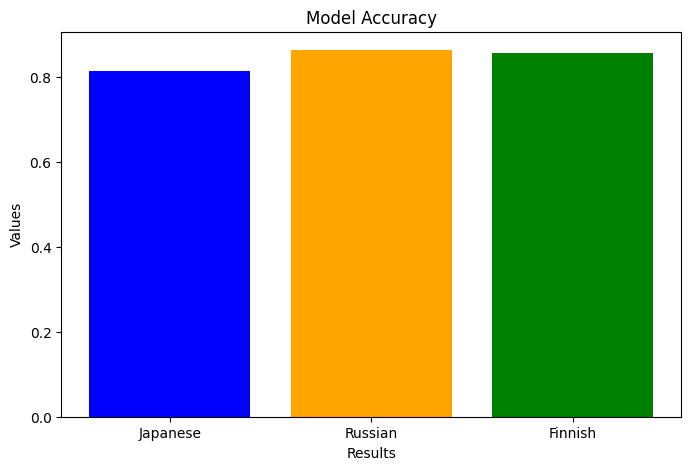

In [ ]:
import matplotlib.pyplot as plt


result1 = validate_model_ja(val_dataloader_ja)
result2 = validate_model_ru(val_dataloader_ru)
result3 = validate_model_fi(val_dataloader_fi)

results = [result1, result2, result3]
labels = ['Japanese', 'Russian', 'Finnish']


plt.figure(figsize=(8, 5))
plt.bar(labels, results, color=['blue', 'orange', 'green'])
plt.xlabel('Results')
plt.ylabel('Values')
plt.title('Model Accuracy')
plt.show()